# LACONEU 2025: Methods of information theory for brain data
# Tutorial # 1: Simulating and measuring synergy and redundancy dominance on continous-valued systems


1. Define synergy and redundancy-dominated Probabilitic Graph Models (PGM) using Gaussian distributions
2. Compute ground truth measures (TC, DTC, O and S) for diferent coupling parameter (c) values
3. Use THOI to estimate the measures
4. Generate a system composed of weak and strong S/R systems and respective ground truths
5. Use optimizations to find the systems


## *Reminder*  : Gaussian Information Theory and O-information

For a $n$-variable Gaussian system $X^n$, entropy $H(X^n)$ is defined as:  

$$H(X^n) = \frac{1}{2} \log ((2\pi e)^n |\Sigma|)$$

Where $\Sigma$ is the covariance matrix and $|\Sigma|$ its determinant.

The O-information ($\Omega$) is:

$$\Omega(X^n) = TC(X^n) - DTC(X^n) = (n - 2) H(X^n) + \sum_{j=1}^n [H(X_j) - H(X^n_{-j})$$


### Defining Probabilistic Graph Models (PGM) 
- **Synergy dominated (S) System**: . Every X is an input to Y. A coupling parameter 'c' parameter controls the effect of all the X over Y. Then, all the X are marginally independent. Its joint PDf follows 

    $p^S(X^n, Y) = p(Y \mid X^n, c) \prod_{j=1}^n p(X_j)$

- **Redundancy dominated (R) System**: . Y is an input to every X in the system. A coupling parameter 'c' parameter controlls the effect of Y over all Xs. Then, all the X are conditionally independent. Its joint PDf follows 

    $p^R(X^n, Y) = p(Y) \prod_{j=1}^n p(X_j \mid Y, c)$

See https://arxiv.org/abs/2404.07140 for details


#### In particular, when X and Y are Normal distributions, their covariance matrices are:


- S-system:
$$
\Sigma_S = 
\begin{bmatrix}
\mathbf{I}_n & c \mathbf{1}_n \\
c \mathbf{1}_n^\top & n c^2 + 1 \\
\end{bmatrix}
$$
where $\mathbf{I}_n$ is the $n \times n$ identity matrix and $\mathbf{1}_n$ is an $n \times 1$ vector of ones.

- R-system:
$$
\Sigma_R = 
\begin{bmatrix}
c^2 + 1 & c^2 & \cdots & c^2 & c \\
c^2 & c^2 + 1 & \cdots & c^2 & c \\
\vdots & \vdots & \ddots & \vdots & \vdots \\
c^2 & c^2 & \cdots & c^2 + 1 & c \\
c & c & \cdots & c & 1 \\
\end{bmatrix}
$$

In [3]:
import numpy as np
from scipy.stats import zscore
from scipy.linalg import block_diag

import matplotlib.pyplot as plt
import seaborn as sns

from thoi.measures.gaussian_copula import nplets_measures
from thoi.heuristics import simulated_annealing, greedy


### Functions to comput the HOI measures from the covariance matrix of gaussian systems.

In [4]:
# Defining functions for computing measures
def gauss_entropy(n, sigma):
    # Entropy of Gaussian system with where logdet is the logarithm of its determinant
    return 0.5*np.log(((2*np.pi*np.exp(1))**(n))*sigma)


def measures_from_covmat(covmat):
    '''
        Brief: Compute the total correlation, dual total correlation, O-information and S-information from the covariance matrix
        
        This function assumes the covariance matrix its a ground truth covariance matrix and hence the measures are computed as the true values.
    '''
    
    N = np.shape(covmat)[0]
    allmin1 = [np.setdiff1d(range(N),x) for x in range(N)]
    detmv = np.linalg.det(covmat) # determinant
    detmv_min_1 = np.array([np.linalg.det(covmat[ids][:,ids]) for ids in allmin1]) # determinant of N-1 subsystems
    single_vars = np.diag(covmat)
    
    var_ents = gauss_entropy(1.0,single_vars)
    sys_ent = gauss_entropy(N,detmv)
    ent_min_one = gauss_entropy(N-1.0,detmv_min_1)

    tc = np.sum(var_ents) - sys_ent
    dtc = np.sum(ent_min_one) - (N-1.0)*sys_ent
    
    return tc, dtc, tc-dtc, tc+dtc


def ids2binary(ids, N):
    binary_matrix = np.zeros((N), dtype=bool)
    binary_matrix[ids] = True

    return binary_matrix

### Function to generate syntehtic data from synergistic and redundant PGM systems

In [5]:
def generate_synergistic_system(n, samples=1000, c=1):
    """
    Generate a synergy-dominated system (S-system) using normal distributions.
    
    In an S-system, the n variables (X_1, ..., X_n) are marginally independent 
    (each drawn from a standard normal distribution). A single variable Y is 
    then generated by taking the sum of all X_i (scaled by a constant c) and 
    adding independent normal noise.
    
    Args:
        n (int): Number of X variables to generate.
        samples (int, optional): Number of samples to draw for each variable. 
                                 Defaults to 1000.
        c (float, optional): Coefficient used to scale the sum of the X variables 
                             in generating Y. Defaults to 1.
    
    Returns:
        np.ndarray: A 2D array of shape (n + 1, samples), where
            - The first n rows correspond to the X_i variables,
            - The last row corresponds to Y.
    
    Example:
        >>> data = generate_S_system(n=3, samples=5, c=2)
        >>> data.shape
        (4, 5)
        # data[0,:] -> X_1 samples
        # data[1,:] -> X_2 samples
        # data[2,:] -> X_3 samples
        # data[3,:] -> Y samples
    """
    # Create a list of n independent normal variables, each shape (samples,).
    X = [np.random.normal(size=samples) for _ in range(n)]
    
    # Generate Y by taking c * (sum of X_i) plus an independent normal noise term.
    Y = c * sum(X) + np.random.normal(size=samples)
    
    # Stack the n X variables and Y into a single array of shape (n+1, samples).
    return np.vstack((X, Y))


def synergistic_system_cov_matrix(n, c):
    """
    Create the theoretical covariance matrix for the synergistic-system.
    
    The S-system has n marginally independent variables X_i (each with variance 1) 
    and a variable Y = c * (sum of X_i) + noise. The resulting covariance matrix 
    is of dimension (n+1) x (n+1), where the last row and column correspond to Y.
    
    Args:
        n (int): Number of X variables.
        c (float): Coefficient scaling the sum of X in generating Y.
    
    Returns:
        np.ndarray: The (n+1) x (n+1) covariance matrix for the S-system.
    
    Explanation of the entries:
        - Each X_i has variance 1 on the diagonal.
        - Y has variance var_Y = n * c^2 + 1. (n * c^2 is from the sum of X_i 
          scaled by c; +1 is from the independent noise in Y.)
        - The covariance between each X_i and Y is c.
        - Off-diagonal entries among X_i are zero, since X_i are independent.
    
    Example:
        >>> Sigma = S_system_cov_matrix(n=3, c=2)
        >>> Sigma.shape
        (4, 4)
        # Sigma[:3, :3] is diagonal with 1's for X_i
        # Sigma[3, 3] is var_Y
    """
    # For X_i ~ N(0, 1)
    var_X_i = 1
    
    # Cov(X_i, Y) = c, because Y = c * sum(X_i) + noise
    cov_X_i_Y = c
    
    # Variance of Y = n*c^2 + 1
    var_Y = n * c**2 + 1
    
    # Initialize the covariance matrix of shape (n+1, n+1) with zeros
    Sigma = np.zeros((n + 1, n + 1))
    
    # Fill the diagonal for the X_i variables
    np.fill_diagonal(Sigma[:n, :n], var_X_i)
    
    # Fill the covariance between each X_i and Y
    Sigma[:n, n] = cov_X_i_Y  # row i, col Y
    Sigma[n, :n] = cov_X_i_Y  # row Y, col i
    
    # Fill the variance of Y
    Sigma[n, n] = var_Y
    
    return Sigma


def generate_redundant_system(n, samples=1000, c=1):
    """
    Generate a redundancy-dominated system (R-system) using normal distributions.
    
    In an R-system, we first generate a variable Y from a standard normal 
    distribution. Each X_i is then generated as a linear function of Y (scaled 
    by c) plus independent normal noise. Conditional on Y, the X_i variables 
    become independent. 
    
    Args:
        n (int): Number of X variables to generate.
        samples (int, optional): Number of samples to draw for each variable. 
                                 Defaults to 1000.
        c (float, optional): Coefficient scaling Y in generating each X_i. 
                             Defaults to 1.
    
    Returns:
        np.ndarray: A 2D array of shape (n + 1, samples), where
            - The first n rows are the X_i variables,
            - The last row is the Y variable.
    
    Example:
        >>> data = generate_R_system(n=3, samples=5, c=2)
        >>> data.shape
        (4, 5)
        # data[0,:] -> X_1 samples
        # data[1,:] -> X_2 samples
        # data[2,:] -> X_3 samples
        # data[3,:] -> Y samples
    """
    # Generate the variable Y ~ N(0, 1)
    Y = np.random.normal(size=samples)
    
    # Generate each X_i as c * Y plus an independent noise term
    X = [c * Y + np.random.normal(size=samples) for _ in range(n)]
    
    # Stack X and Y into an array of shape (n+1, samples)
    return np.vstack((X, Y))


def redundant_system_cov_matrix(n, c):
    """
    Create the theoretical covariance matrix for the R-system.
    
    The R-system has a variable Y ~ N(0,1). Each X_i is generated as 
    X_i = c * Y + noise (noise ~ N(0,1)). The resulting covariance matrix 
    is of dimension (n+1) x (n+1), where the last row/column corresponds to Y.
    
    Args:
        n (int): Number of X variables.
        c (float): Coefficient scaling Y when generating each X_i.
    
    Returns:
        np.ndarray: The (n+1) x (n+1) covariance matrix for the R-system.
    
    Explanation of the entries:
        - Y has variance 1 on the diagonal.
        - Each X_i has variance c^2 + 1 (because X_i = c*Y + noise, each with 
          variance c^2 + 1).
        - Cov(X_i, X_j) = c^2 for i != j (they share dependence on Y).
        - Cov(X_i, Y) = c.
    
    Example:
        >>> Sigma = R_system_cov_matrix(n=3, c=2)
        >>> Sigma.shape
        (4, 4)
        # The top-left 3x3 block is the covariances among X_1..X_3
        # Sigma[3,3] is the variance of Y.
    """
    # The variance of each X_i is c^2 + 1
    var_X_i = c**2 + 1
    
    # The covariance among different X_i is c^2 (since they share Y in common)
    cov_X_i_X_j = c**2
    
    # The covariance between each X_i and Y is c
    cov_X_i_Y = c
    
    # Y has variance 1
    var_Y = 1
    
    # Start with a matrix full of c^2 to fill off-diagonal X_i-X_j
    Sigma = np.full((n + 1, n + 1), cov_X_i_X_j)
    
    # Fill the diagonal with var_X_i for X_1..X_n 
    # and later we'll fix the diagonal entry for Y
    np.fill_diagonal(Sigma, var_X_i)
    
    # Covariances between each X_i and Y
    Sigma[:n, n] = cov_X_i_Y
    Sigma[n, :n] = cov_X_i_Y
    
    # Fill variance of Y on the diagonal
    Sigma[n, n] = var_Y
    
    return Sigma


### Function to plot the data and the obtained solutions 

In [6]:
def plot_solutions_by_order(greedy_out, title, minimization=True, ax=None):
    
    # Definition of the plot parameters. All this can be parametrized to be customizable
    yticklabels = ['Weak Red', 'Strong Red', 'Weak Syn', 'Strong Syn', 'Indep.']
    n=5
    N=30
    min_k=3
    colors = sns.color_palette("tab10", n_colors=5, as_cmap=False)
    colors = np.vstack([color for color in colors for _ in range(1)])
    colors = np.vstack((np.ones(3),colors))
    colors = sns.color_palette(colors)
    xticks = np.arange(n+1, N, n+1)

    # Extracting values from paramters
    argopt = np.argmin if minimization else np.argmax
    greedy_nplets, greedy_scores = greedy_out    
    
    # Extracting best per order
    g_id = argopt(greedy_scores, axis=0)
    g_best_part_k = greedy_nplets[g_id]
    g_best_part_k = [np.sort(g_best_part_k[k,:(min_k+k)]) for k in range(0, norders)]

    # Converting selected variables into colored matrices
    g_best_part_k_mat = np.vstack([ids2binary(x, N) for x in g_best_part_k])*1.0
    for i in range(N):
        g_best_part_k_mat[:, i] = (g_best_part_k_mat[:, i] != 0) * (i // (n+1) + 1)

    # Plotting
    ax = sns.heatmap(g_best_part_k_mat.T, cmap=colors, yticklabels=[], xticklabels=[], cbar=None, linecolor='k', ax=ax)
    ax.set_title(title)
    ax.set_xlabel('Order of Interaction')
    ax.set_xticks(xticks-min_k, labels=xticks)
    ax.set_yticks(np.arange((n+1)/2, N, n+1), labels=yticklabels)
    ax.grid(axis='x')
    
    for spine in ax.spines.values():
        spine.set_visible(True)
        spine.set_linewidth(1.5)
        spine.set_color('black')


def plot_max_min_values_by_order(greedy_out_max, greedy_out_min, ground_thrut, ax=None):
    
    # Parameter definition
    N=30
    n=5
    min_k=3
    xx = np.arange(min_k,N+1)

    # Extracting values from ground truth
    oinfo_redundant_strong = ground_thrut[1]
    oinfo_redundant_all = np.sum(ground_thrut[:2])
    oinfo_synergistic_strong = ground_thrut[3]
    oinfo_synergistic_all = np.sum(ground_thrut[2:])

    # Extract max and min scores by order
    g_max_scores = np.vstack(greedy_out_max[1])
    g_max_vals_k = np.max(g_max_scores,axis=0)
    g_min_scores = np.vstack(greedy_out_min[1])
    g_min_vals_k = np.min(g_min_scores,axis=0)

    # Plotting
    ax.plot(xx,g_max_vals_k, 'r.-', label='greedy max')
    ax.plot(xx,g_min_vals_k, 'b.-', label='greedy min')
    ax.fill_between(xx, g_min_vals_k, g_max_vals_k, alpha=0.2)

    ax.axhline(y=0, color='k', linestyle='--')
    ax.axhline(y=oinfo_redundant_strong, color='r', linestyle='--', label='GT O(Strong Red)')
    ax.axhline(y=oinfo_synergistic_strong, color='b', linestyle='--', label='GT O(Strong Syn)')
    ax.axhline(y=oinfo_redundant_all, color='r', linestyle=':', label='GT O(Strong Red) + O(Weak Red)')
    ax.axhline(y=oinfo_synergistic_all, color='b', linestyle=':', label='GT O(Strong Syn) + O(Weak Syn)')
    
    ax.grid(True)
    ax.set_ylabel('O-information (nats)')
    ax.set_xlabel('Order of Interaction')
    ax.legend(fontsize=14, loc='center')
    ax.set_xticks(np.arange(n+1, N, n+1))


def plot_generated_joint_data(X):    

    # Values to parametrize to play with the data
    xlim=500
    n = 5
    n_subsystems = 5
    offset = 6 # the offset to print each variable one after the other separated by a gap of offset

    N = X.shape[1]

    yticks = np.arange(((n)*offset)/2, (N+1)*offset+1, (n+1)*offset)
    yticklabels = ['Weak Red', 'Strong Red', 'Weak Syn', 'Strong Syn', 'Indep.']
    colors = sns.color_palette("tab10", n_colors=n_subsystems)
    colors = [color for color in colors for _ in range(n+1)]

    plt.figure(figsize=(16,6))

    for i in range(X.shape[1]):
        if (i+1)%(n+1)==0:
            plt.plot(zscore(X[:, i]) + i*offset, color=colors[i], linewidth=1.5)
        else:
            plt.plot(zscore(X[:, i]) + i*offset, color=colors[i], linewidth=0.5)
            
    plt.xlim([0,xlim])
    plt.yticks(yticks, labels=yticklabels)
    plt.show()

### Computing ground truth measures and generating data from PGMs using different coupling values

In [7]:
# Computing ground truth measures for Gaussian
# entropy function
meas_names = ['TC', 'DTC', 'O', 'S']
n_meas = len(meas_names) # number of measures; tc, dtc, o, s

# Parameters for the data geneartion
n = 3 # Number of X variables of the PGM systems, the systems have n+1 variables (X_i and Y)
n_samples = 10000 # Number of samples to generate for each system
n_cs = 10
cs = np.linspace(0, 1, n_cs)

# Storing ground truth
synergistic_measures = np.zeros((n_cs, n_meas))
redundant_measures = np.zeros((n_cs, n_meas))

# Storing simulated data
synergistic_data = [None]*n_cs
redundant_data = [None]*n_cs

# Storing estimated covariance data
synergistic_estimated_comvat = [None]*n_cs
redundant_estimated_comvat = [None]*n_cs


# Loop over cs and compute ground truth measures
for c_id, c in enumerate(cs):
    # Generate Covariance for R and Ssystems
    synergistic_C = synergistic_system_cov_matrix(n,c)
    redundant_C = redundant_system_cov_matrix(n,c)
    
    # Compute Ground Truth measures
    synergistic_measures[c_id, :] = measures_from_covmat(synergistic_C)
    redundant_measures[c_id, :] = measures_from_covmat(redundant_C)
    
    # Generate data using covariance matrices
    synergistic_data[c_id] = generate_synergistic_system(n, n_samples, c)
    redundant_data[c_id] = generate_redundant_system(n, n_samples, c)
    
    # Estimating covariance matrix from data
    synergistic_estimated_comvat[c_id] = np.cov(synergistic_data[c_id])
    redundant_estimated_comvat[c_id] = np.cov(redundant_data[c_id])
    
## Estimating measures using THOI and pre-computed covariance matrices
synergistic_estimated_meas = np.squeeze(np.array(nplets_measures(np.array(synergistic_estimated_comvat), covmat_precomputed=True, T=n_samples)))
redundant_estimated_meas = np.squeeze(np.array(nplets_measures(np.array(redundant_estimated_comvat), covmat_precomputed=True, T=n_samples)))


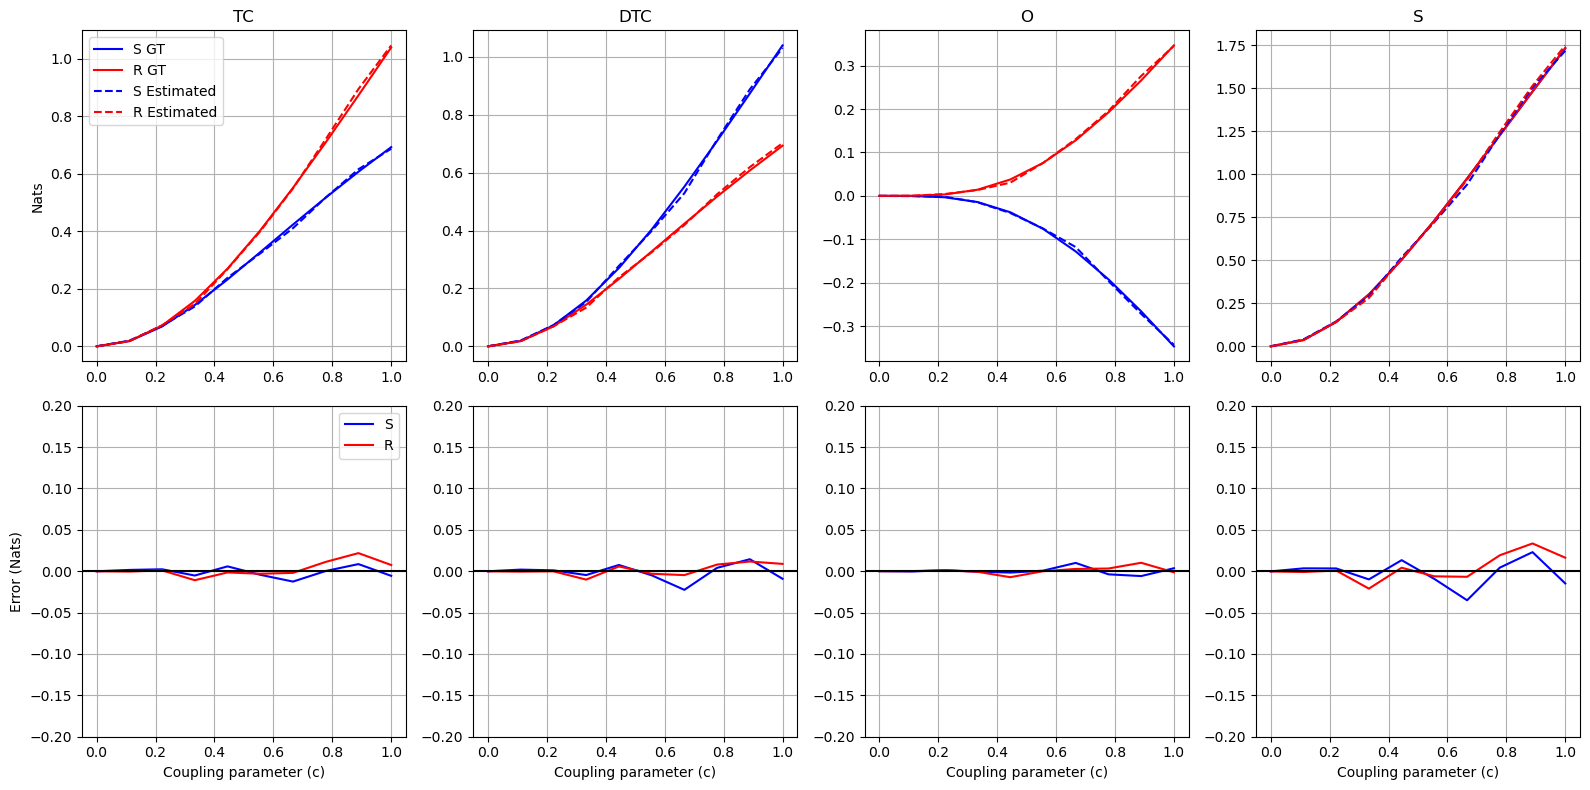

In [8]:
# Plotting measures and estimation error
errlims = [-0.2, 0.2]
fig = plt.figure(figsize=(16,8))

for meas in range(n_meas):
    # Measure vs c
    plt.subplot(2, n_meas, meas+1)
    # Ground truth measures
    plt.plot(cs, synergistic_measures[:, meas], color='b', label='S GT')
    plt.plot(cs, redundant_measures[:, meas], color='r', label='R GT')
    # Estimated measures
    plt.plot(cs, synergistic_estimated_meas[:, meas], color='b', ls='--', label='S Estimated')
    plt.plot(cs, redundant_estimated_meas[:, meas], color='r', ls='--', label='R Estimated')

    plt.grid()
    plt.title(meas_names[meas])
    if meas==0:
        plt.ylabel('Nats')
        plt.legend()

    # Estimation error vs c
    plt.subplot(2, n_meas, n_meas+meas+1)
    plt.plot(cs, synergistic_estimated_meas[:, meas] - synergistic_measures[:, meas], color='b', label='S')
    plt.plot(cs, redundant_estimated_meas[:, meas] - redundant_measures[:, meas], color='r', label='R')
    plt.axhline(0, color='k')
    plt.xlabel('Coupling parameter (c)')
    plt.grid()
    plt.ylim(errlims)
    
    if meas==0:
        plt.ylabel('Error (Nats)')
        plt.legend()
    
    
plt.tight_layout()
plt.show()

### Excercise: Compute the same for a concatenated system composed of R and S
For each 'c', create a system that is composed of a R and a S system of the same size, generate data and estimate the measures.

Is    $O(R_c,S_c) = O(R_c) + O(S_c)$?


Show it numerically and discuss it theoretically.


Note: there are two ways to generate syntetic data from concatenated PGM systems:
1. Generate multiple covariance matrices and concatenate them. Then use numpy to generate the data from the covariance.
2. Generate the data from each system and concatenate them.

In [9]:
mixed_system_measures = np.zeros((n_cs, n_meas))
mixed_system_data = [None]*n_cs
mixed_system_estimated_comvat = [None]*n_cs

for c_id, c in enumerate(cs):

    synergistic_covmatrix = synergistic_system_cov_matrix(n,c)
    redundant_covmatrix = redundant_system_cov_matrix(n,c)

    syn_data = generate_synergistic_system(n, n_samples//2, c)
    red_data = generate_redundant_system(n, n_samples//2 + n_samples % 2, c)
    





     # Generate Covariance for R and Ssystems
    synergistic_C = synergistic_system_cov_matrix(n,c)
    redundant_C = redundant_system_cov_matrix(n,c)
    
    # Compute Ground Truth measures
    synergistic_measures[c_id, :] = measures_from_covmat(synergistic_C)
    redundant_measures[c_id, :] = measures_from_covmat(redundant_C)
    
    # Generate data using covariance matrices
    synergistic_data[c_id] = generate_synergistic_system(n, n_samples, c)
    redundant_data[c_id] = generate_redundant_system(n, n_samples, c)
    
    # Estimating covariance matrix from data
    synergistic_estimated_comvat[c_id] = np.cov(synergistic_data[c_id])
    redundant_estimated_comvat[c_id] = np.cov(redundant_data[c_id])
    

-----------------------------------------------------------------------------------------------------

### Using optimization approaches for larger systems: Greddy and Simulated Annealing

Now we will construct a system of 30 variables, composed by 5 concatenated subsystems of 6 variables: weak R/S (c=0.5), strong R/S (c=1) and one system of independent variables.

Then, we will use the Greedy Algorithm to find the n-plet that maximizes/minimizes the O-information at each order of interaction.

Finally, we will use the Simulated Annealing to check results at specific orders of interaction

Redundant weak O-information: 0.1523920770317826
Redundant strong O-information: 0.836986523640256
Synergistic weak O-information: -0.15239546332293763
Synergistic strong O-information: -0.83698990993142


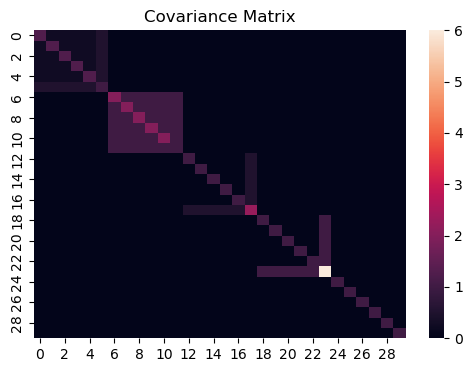

In [10]:
# The systems number of X-variables. The system total number of variables is n+1 (X_1, ..., X_n, Y)
n = 5

# Redundant weak
redundant_weak_C = redundant_system_cov_matrix(n, 0.5)
redundant_weak_oinfo = nplets_measures(np.array([redundant_weak_C]), covmat_precomputed=True)[0,0,2].cpu().numpy()
print('Redundant weak O-information:', redundant_weak_oinfo)

# Redundant strong
redundant_strong_C = redundant_system_cov_matrix(n, 1.0)
redundant_strong_oinfo = nplets_measures(np.array([redundant_strong_C]), covmat_precomputed=True)[0,0,2].cpu().numpy()
print('Redundant strong O-information:', redundant_strong_oinfo)

# Synergistic weak
synergistic_weak_C = synergistic_system_cov_matrix(n, 0.5)
synergistic_weak_oinfo = nplets_measures(np.array([synergistic_weak_C]), covmat_precomputed=True)[0,0,2].cpu().numpy()
print('Synergistic weak O-information:', synergistic_weak_oinfo)

# Synergistic strong
synergistic_strong_C = synergistic_system_cov_matrix(n, 1.0)
synergistic_strong_oinfo = nplets_measures(np.array([synergistic_strong_C]), covmat_precomputed=True)[0,0,2].cpu().numpy()
print('Synergistic strong O-information:', synergistic_strong_oinfo)

# Independent
independent_C = np.eye(n+1)

# Constructing the joint covariance matrix
C_joint = block_diag(redundant_weak_C, redundant_strong_C, synergistic_weak_C, synergistic_strong_C, independent_C)

# Plotting the final covariance matrix
plt.figure(figsize=(6,4))
sns.heatmap(C_joint)
plt.title('Covariance Matrix')
plt.show()

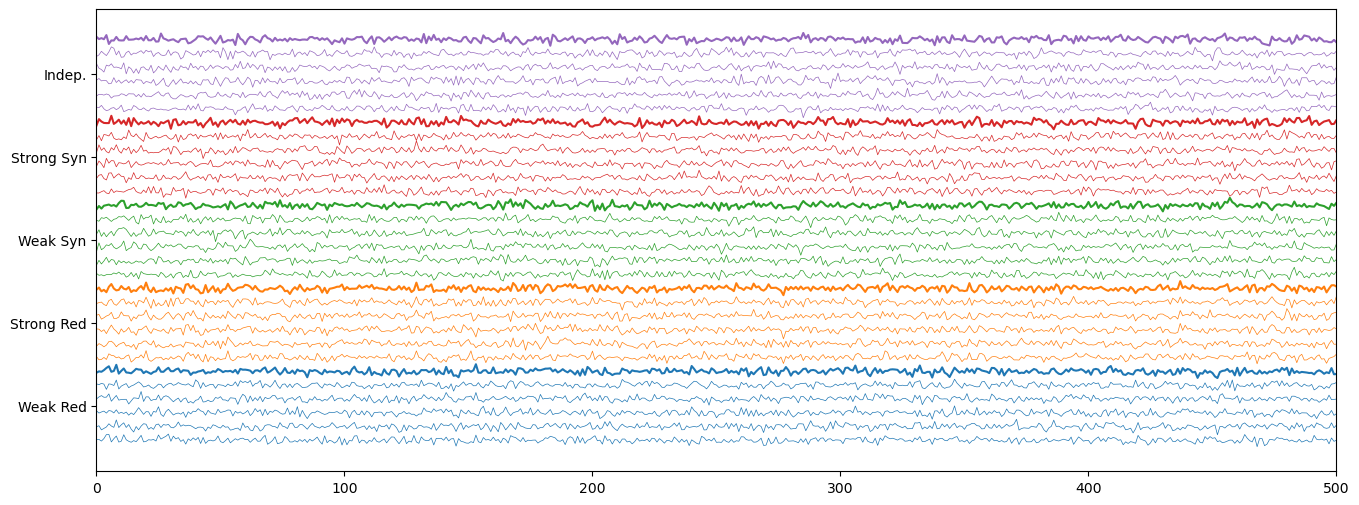

In [11]:
# Generating data and plotting
T = 100000
N = len(C_joint)
X = np.random.multivariate_normal(np.zeros(N), C_joint, size=T)

plot_generated_joint_data(X)

### Using Greedy Alorithm to find the maximum/minimum O-information at each order of interaction

In [12]:
# Running greedy
max_k = len(C_joint)
min_k = 3
norders = max_k - min_k +1

g_repeat = 10000
# Maximize
greedy_out_max = greedy(X, initial_order=min_k, order=max_k, repeat=g_repeat, metric='o', largest=True)
# Minimize
greedy_out_min = greedy(X, initial_order=min_k, order=max_k, repeat=g_repeat, metric='o', largest=False)

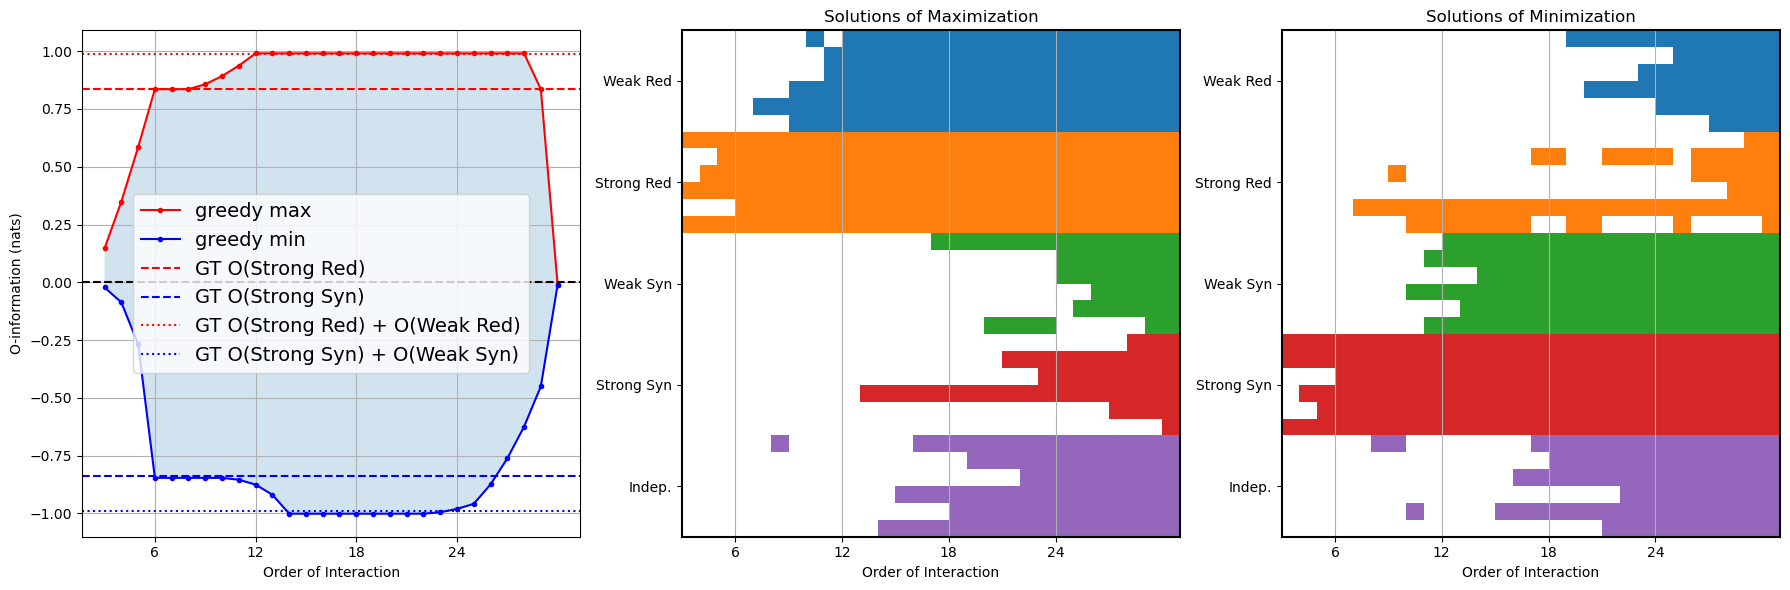

In [13]:
fig, axes = plt.subplots(1,3, figsize=(18,6))

ground_thrut = [
    redundant_weak_oinfo,
    redundant_strong_oinfo,
    synergistic_weak_oinfo,
    synergistic_strong_oinfo
]

plot_max_min_values_by_order(greedy_out_max, greedy_out_min, ground_thrut, ax=axes[0])
plot_solutions_by_order(greedy_out_max, 'Solutions of Maximization', minimization=False, ax=axes[1])
plot_solutions_by_order(greedy_out_min, 'Solutions of Minimization', minimization=True, ax=axes[2])

plt.tight_layout()
plt.show()

### Use Simulated Annealing to find the max/min O-informtion at specific orders (6 and 12)

In [14]:
# Example wth 6.
sa_repeat = 10
early_stop = 1000 # play with this

# Maximization
sa_out_max = simulated_annealing(X, order=6, repeat=sa_repeat, metric='o', largest=True, early_stop=early_stop)
max_scores = np.vstack(sa_out_max[1])
sa_max_vals_k = np.squeeze(np.max(max_scores))
max_vals_k_id = np.squeeze(np.argmax(max_scores))
sa_best_max_part_k = sa_out_max[0][max_vals_k_id]

# Minimization
sa_out_min = simulated_annealing(X, order=6, repeat=sa_repeat, metric='o', largest=False, early_stop=early_stop)
min_scores = np.vstack(sa_out_min[1])
sa_min_vals_k = np.squeeze(np.min(min_scores))
min_vals_k_id = np.squeeze(np.argmin(min_scores))
sa_best_min_part_k = sa_out_min[0][min_vals_k_id]

# Printing results
print(f'SA Max Estimate: {sa_max_vals_k}')
print(f'SA Max Variables: {np.sort(sa_best_max_part_k)}\n')
print(f'SA Min Estimate: {sa_min_vals_k}'), 
print(f'SA Min Variables: {np.sort(sa_best_min_part_k)}\n')

SA Max Estimate: 0.8357488955523653
SA Max Variables: [ 6  7  8  9 10 11]

SA Min Estimate: -0.8464931493893655
SA Min Variables: [18 19 20 21 22 23]



### Now do the same for order = 12 and discuss the results

In [15]:
# Complete here